### Import Libraries

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import warnings
warnings.filterwarnings(action='ignore')

2022-11-11 22:00:46.337966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 22:00:46.456119: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-11 22:00:46.484024: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 22:00:47.035850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### VAE Encoder Network

In [2]:
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape = img_shape)

x = layers.Conv2D(32,3,padding='same',activation='relu')(input_img)
x = layers.Conv2D(64,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

### Latent space sampling

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(
        shape = (K.shape(z_mean)[0], latent_dim), mean = 0, stddev=1.
    )
    return z_mean+K.exp(0.5*z_log_var)*epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

### VAE Decoder Network

In [4]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(
    np.prod(shape_before_flattening[1:]), activation = 'relu'
)(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)

decoder = Model(decoder_input,x)

z_decoded = decoder(z)

### VAE Loss Calculation Layer

In [5]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x,z_decoded)
        kl_loss = -5e-4*K.mean(
            1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1
        )
        
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs = inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

### Training VAE

In [6]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)
vae.summary()

(x_train, _),(x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(
    x = x_train, y = None, shuffle = True, 
    epochs = 10, batch_size = batch_size, 
    validation_data = (x_test, None)
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

2022-11-11 22:00:48.695290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 22:00:49.888335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22101 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-11-11 22:00:49.888931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21959 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:18:00.0, compute capability: 8.6
2022-11-11 22:00:49.889342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/t

60000/60000 [==============================] - 44s 729us/sample - loss: 0.2152 - val_loss: 0.1993
Epoch 2/10
60000/60000 [==============================] - 40s 665us/sample - loss: 0.1961 - val_loss: 0.1923
Epoch 3/10
60000/60000 [==============================] - 40s 667us/sample - loss: 0.1913 - val_loss: 0.1892
Epoch 4/10
60000/60000 [==============================] - 40s 664us/sample - loss: 0.1886 - val_loss: 0.1884
Epoch 5/10
60000/60000 [==============================] - 40s 668us/sample - loss: 0.1869 - val_loss: 0.1855
Epoch 6/10
60000/60000 [==============================] - 40s 671us/sample - loss: 0.1858 - val_loss: 0.1852
Epoch 7/10
60000/60000 [==============================] - 40s 665us/sample - loss: 0.1848 - val_loss: 0.1843
Epoch 8/10
60000/60000 [==============================] - 40s 664us/sample - loss: 0.1841 - val_loss: 0.1844
Epoch 9/10
60000/60000 [==============================] - 40s 665us/sample - loss: 0.1835 - val_loss: 0.1851
Epoch 10/10
60000/60000 [=====

### Image Decoding

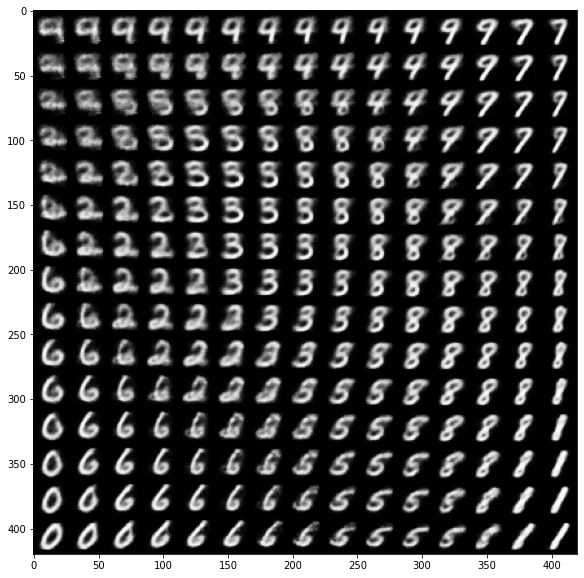

In [7]:
import matplotlib.pyplot as plt

from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # 15 × 15 숫자의 그리드를 출력합니다
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 싸이파이 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 만듭니다
# 잠재 공간의 사전 확률은 가우시안입니다
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()